In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt





In [18]:
def frog_portfolio(price_daily,price_monthly,start1,end1,start2,end2,k):
    rtns_daily=np.log(price_daily/price_daily.shift(1))*100
    rtns_monthly=np.log(price_monthly/price_monthly.shift(1))*100
    rtn_id=pd.DataFrame(index=rtns_monthly.index,columns=rtns_monthly.columns)
    for month in rtns_monthly.index:
        for ticker in rtns_monthly.columns:
            a=rtns_daily.loc[str(month)[:7],ticker]
            ID=np.sign(rtns_monthly.loc[month,ticker])*(len(a[a<0])-len(a[a>=0]))/len(a)
            rtn_id.loc[month,ticker]=ID
    mom_k=np.log(price_monthly/price_monthly.shift(k))*100
    rtns_daily=rtns_daily.iloc[1:]
    rtns_monthly=rtns_monthly.iloc[1:]
    mom_k=mom_k.iloc[k:]
    mom_k = mom_k.shift(1)
    mom_k = mom_k.iloc[1:]

    if len(mom_k)<len(rtns_monthly):
        rtns_monthly=rtns_monthly.reindex(mom_k.index)
        rtn_id=rtn_id.reindex(mom_k.index)
    else:
        mom_k=mom_k.reindex(rtns_monthly.index)
        rtn_id=rtn_id.reindex(rtns_monthly.index)

    #tickers=list(mom_k.columns)
    date_return_tickers = dict()
    for i in tqdm(range(1,len(mom_k))):
        mom_winners=mom_k.iloc[i].dropna().rank(method='first',ascending=False)\
            [(mom_k.iloc[i].dropna().rank(method='first',ascending=False)<end1)&\
                (mom_k.iloc[i].dropna().rank(method='first',ascending=False)>=start1)].index.values
        mom_winners=list(mom_winners)
        id_new=rtn_id[mom_winners].copy()
        winners=id_new.iloc[i].dropna().rank(method='first',ascending=True)\
            [(id_new.iloc[i].dropna().rank(method='first',ascending=True)<end2)&\
                (id_new.iloc[i].dropna().rank(method='first',ascending=True)>=start2)].index.values
        winners=list(winners)
        date_return_tickers[rtns_monthly.index[i]] = \
        [[np.dot(rtns_monthly.iloc[i].reindex(winners).fillna(-99).values, np.array([1/len(winners) for i in range(len(winners))]))-0.015], winners]

    return date_return_tickers


def winner_portfolio(price_panel, k,start,end):
    rtn_panel = (np.log(price_panel) - np.log(price_panel.shift(1))) * 100
    mom_k = (np.log(price_panel) - np.log(price_panel.shift(k))) * 100
    rtn_panel = rtn_panel.iloc[1:]
    mom_k = mom_k.iloc[k:]
    mom_k = mom_k.shift(1)
    mom_k = mom_k.iloc[1:]

    rtn_panel = rtn_panel.reindex(mom_k.index)

    date_return_tickers = dict()

    for i in range(len(mom_k)):
        winners = mom_k.iloc[i].dropna().rank(method='first',ascending=False)\
        [(mom_k.iloc[i].dropna().rank(method='first',ascending=False)<end) & \
        ((mom_k.iloc[i].dropna().rank(method='first',ascending=False)>=start))].index.values
        winners = list(winners)
        # print(len(winners))
        # print(rtn_panel.iloc[i].reindex(winners).fillna(-99).values)
        date_return_tickers[rtn_panel.index[i]] = \
        [[np.dot(rtn_panel.iloc[i].reindex(winners).fillna(-99).values, np.array([1/len(winners) for i in range(len(winners))]))], winners]
        

    return date_return_tickers




In [27]:
price_daily=pd.read_csv('price_panel.csv',index_col=0,parse_dates=True)
price_monthly=pd.read_csv('price_panel_monthend1.csv',index_col=0,parse_dates=True)
several_k = [3,6,9,12]

portfolio_13 = pd.DataFrame(index = price_monthly.index)

for k in tqdm(several_k):
  frog_momentum = frog_portfolio(price_daily=price_daily,price_monthly = price_monthly, k = k,start1=1,end1=101,start2=1,end2=11)
  momentum_k = winner_portfolio(price_panel= price_monthly,start=1,end=101, k = k)
  portfolio_13['momentum'+str(k)] = pd.Series(np.array([rtn[0] for rtn in list(momentum_k.values())]).flatten(), index = momentum_k.keys())
  portfolio_13['frog'+str(k)] =  pd.Series(np.array([rtn[0] for rtn in list(frog_momentum.values())]).flatten(), index = frog_momentum.keys())
  

100%|██████████| 4/4 [07:51<00:00, 117.86s/it]


In [28]:
print("mean","\n",portfolio_13.mean())
print("")
print("std","\n",portfolio_13.std())
print("")
print("skewness","\n",portfolio_13.skew())
print("")
print("kurtosis","\n",portfolio_13.kurtosis())
print("")
print("sharpe ratio","\n", portfolio_13.mean() / portfolio_13.std())

mean 
 momentum3    -1.234144
frog3         2.529091
momentum6    -1.178051
frog6         2.105880
momentum9    -1.158066
frog9         1.542533
momentum12   -1.209858
frog12        1.356319
dtype: float64

std 
 momentum3      6.098420
frog3         15.975616
momentum6      6.202079
frog6         14.980794
momentum9      6.364805
frog9         15.882641
momentum12     6.486798
frog12        15.536879
dtype: float64

skewness 
 momentum3    -0.705416
frog3        -0.191486
momentum6    -0.647453
frog6        -0.328877
momentum9    -0.725039
frog9        -0.166487
momentum12   -0.687610
frog12       -0.026768
dtype: float64

kurtosis 
 momentum3     1.060971
frog3         0.722835
momentum6     0.848872
frog6        -0.182917
momentum9     1.381582
frog9        -0.367132
momentum12    2.085016
frog12       -0.384083
dtype: float64

sharpe ratio 
 momentum3    -0.202371
frog3         0.158309
momentum6    -0.189945
frog6         0.140572
momentum9    -0.181948
frog9         0.097121
mome

<AxesSubplot:xlabel='Date'>

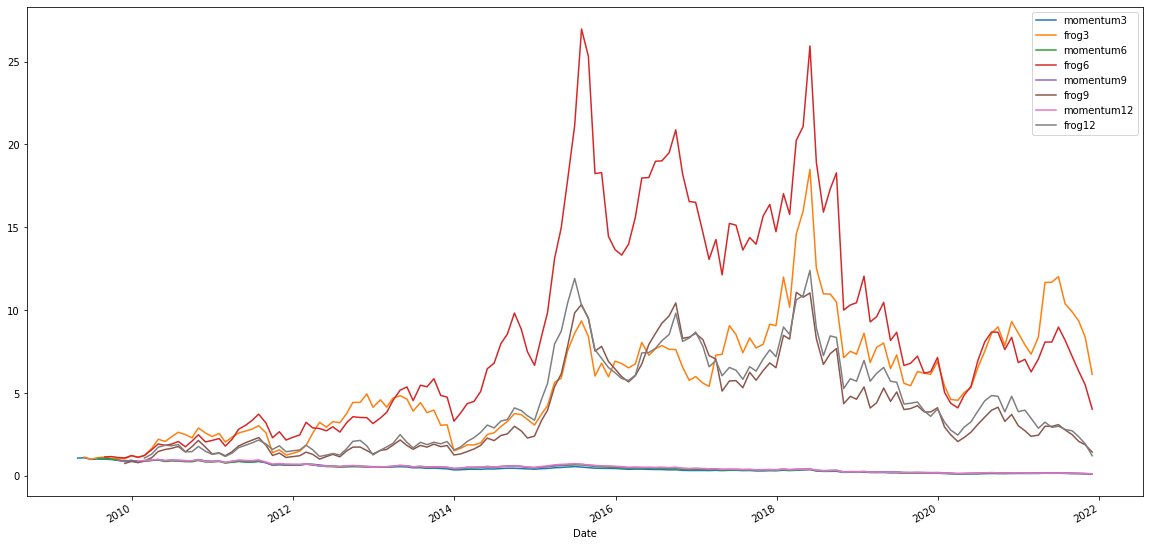

In [29]:
port = portfolio_13[['momentum3','frog3','momentum6','frog6','momentum9','frog9','momentum12','frog12']] / 100
(1+port).cumprod().plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

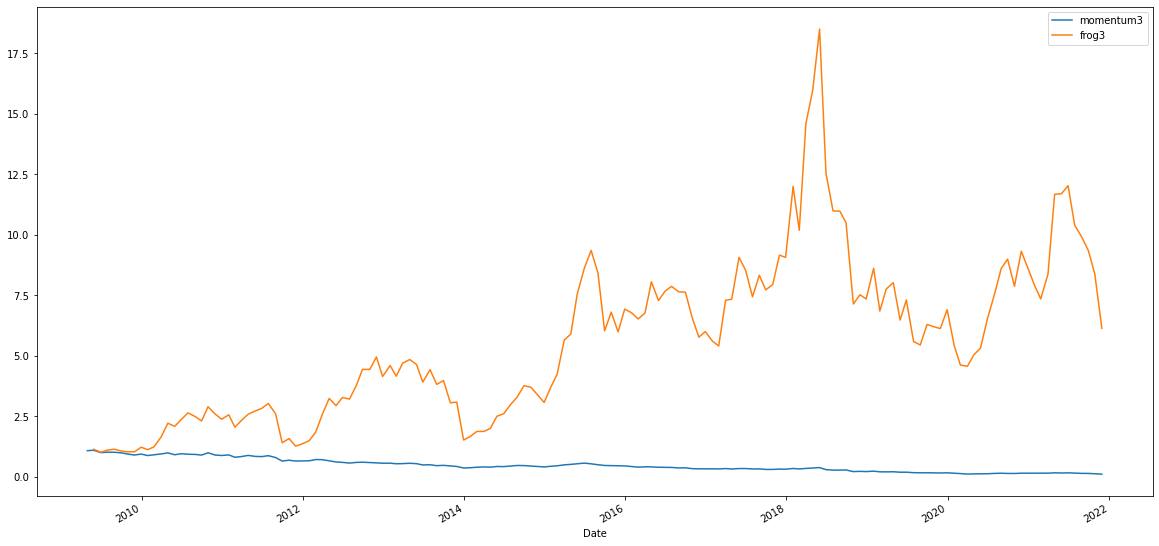

In [30]:
port = portfolio_13[['momentum3','frog3']]/100
(1+port).cumprod().plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

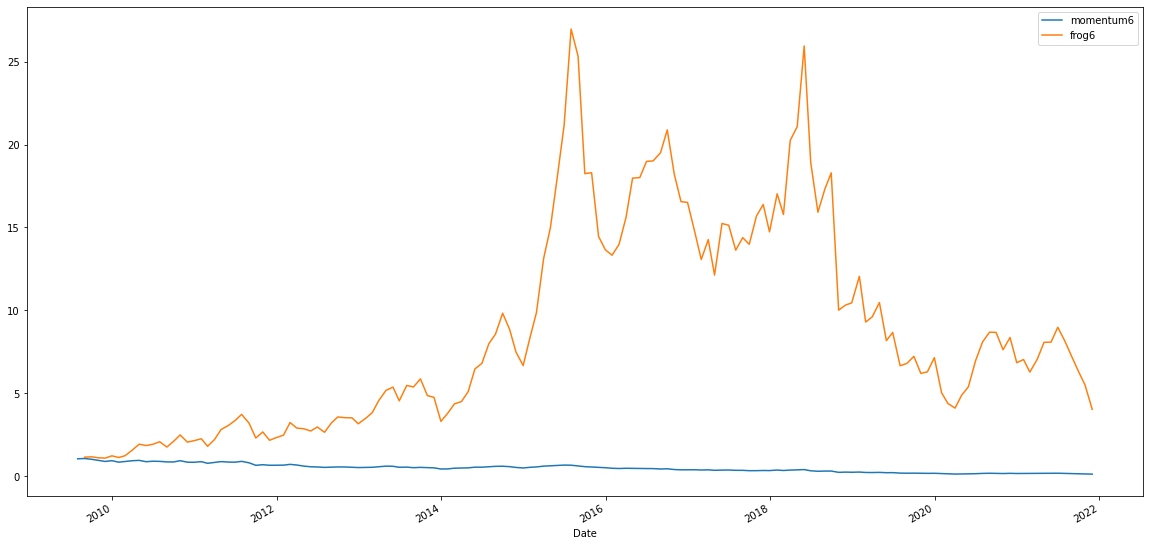

In [31]:
port = portfolio_13[['momentum6','frog6']]/100
(1+port).cumprod().plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

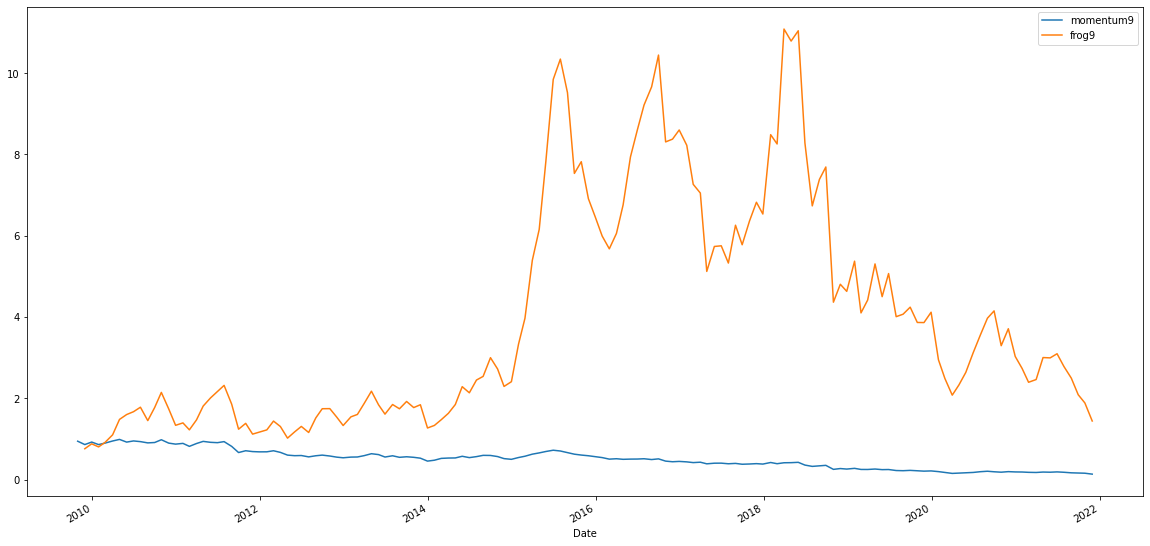

In [32]:
port = portfolio_13[['momentum9','frog9']]/100
(1+port).cumprod().plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

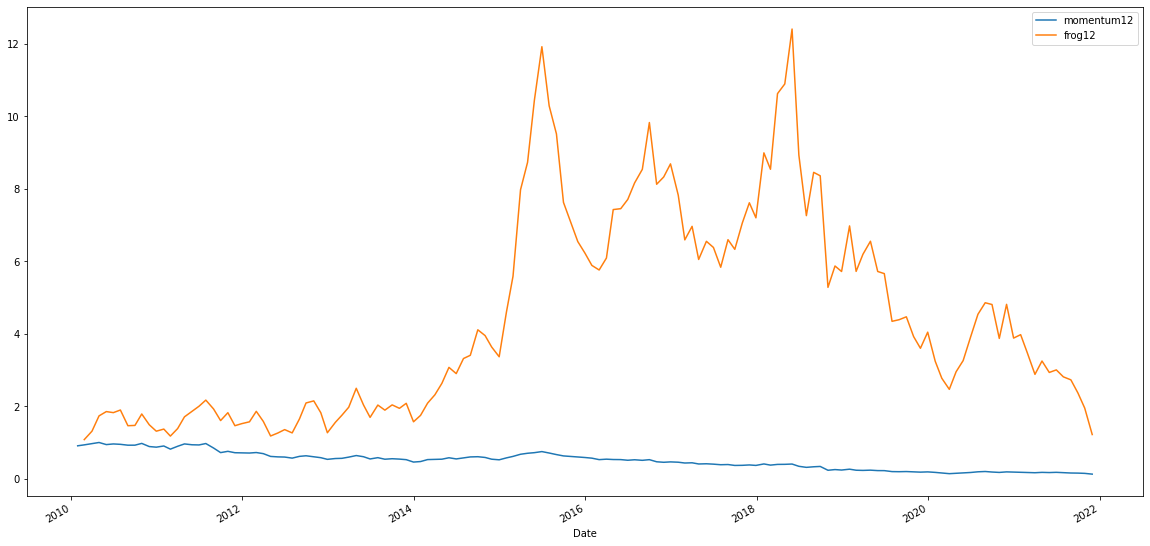

In [33]:
port = portfolio_13[['momentum12','frog12']]/100
(1+port).cumprod().plot(figsize=(20,10))